In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import time

from numpy.ctypeslib import ndpointer
import ctypes

import warnings
warnings.filterwarnings('ignore')

In [2]:
tickers = ['BTC', 'ETH', 'XRP', 'DOGE','ETC']
path = './data/'+tickers[0]+'-M.csv'
df = pd.read_csv(path,parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head(3)

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359


In [3]:
from pymodule.dllMod import pred_per
pred = pred_per(df, 0.04)

In [4]:
from pymodule.dataMod import OHLCDataset

seq_length = 70
dataset = OHLCDataset(df[10:-4], pred[10:-4], seq_length)

In [5]:
from torch.utils.data import DataLoader, random_split

test_size = 262144
train_set, test_set = random_split(dataset, [len(dataset) - test_size, test_size])
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')

train_dloader = DataLoader(train_set, batch_size=512, shuffle=True, drop_last=True)
test_dloader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True)

train dataset length : 1523574
test dataset length : 262144


In [6]:
train_features, train_labels = next(iter(train_dloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([512, 4, 70, 5])
Labels batch shape: torch.Size([512, 1])


In [7]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [8]:
from pymodule.models import OLNN

model = OLNN(seq_length).to(device)

optimizer = optim.SGD(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

In [10]:
path = "./OLNN.pt"
losses = []
val_losses = []
model = torch.load(path).to(device)

In [14]:
from pymodule.models import fit

start = time.time()
for epoch in range(60):
    epoch_loss = fit(epoch,model,train_dloader, criterion, optimizer, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dloader, criterion, optimizer, phase ='valid')
    val_losses.append(val_epoch_loss)
    print("{:0,.2f}분".format((time.time()-start)/60))
torch.save(model, path)

epoch:0, trainloss is 0.0001669484667565639
epoch:0, validloss is 0.00016197141836116202
1.32분
epoch:1, trainloss is 0.00016728758825379172
epoch:1, validloss is 0.0001619715899696672
2.63분
epoch:2, trainloss is 0.0001672266142541695
epoch:2, validloss is 0.0001619713275413659
3.90분
epoch:3, trainloss is 0.00016714391636056192
epoch:3, validloss is 0.00016196994628536743
5.17분
epoch:4, trainloss is 0.0001671812074315525
epoch:4, validloss is 0.00016197021221131536
6.44분
epoch:5, trainloss is 0.00016732983644529616
epoch:5, validloss is 0.0001619703948101403
7.71분
epoch:6, trainloss is 0.00016697705839395825
epoch:6, validloss is 0.0001619699612760428
8.98분
epoch:7, trainloss is 0.00016733435085239444
epoch:7, validloss is 0.000161970498973929
10.24분
epoch:8, trainloss is 0.0001673555340614878
epoch:8, validloss is 0.00016196990392280952
11.51분
epoch:9, trainloss is 0.00016712744816065728
epoch:9, validloss is 0.00016196984778460433
12.78분
epoch:10, trainloss is 0.00016688236145119434
e

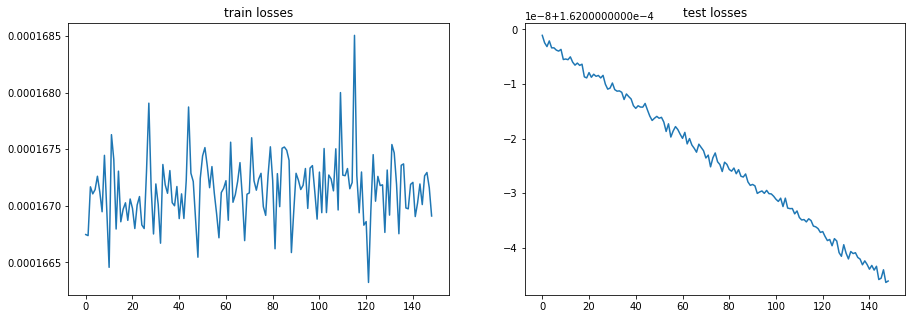

In [17]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('train losses')

ax[1].plot(val_losses)
ax[1].set_title('test losses')
plt.show()